In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath("../.."))
from dotenv import load_dotenv

load_dotenv("../../.env", override=True)

from examples.config import settings

%load_ext autoreload
%autoreload 2

# AI Ideation Agent

This notebook demonstrates an **orchestrating AI ideation agent** using the `deepagents` package.

## Deep Agent Pattern Demonstrated

1. **PLANNING**: Uses `write_todos` to plan the ideation session before starting
2. **GUIDING**: Leads users through a 9-section AI Use Case Canvas conversationally
3. **DELEGATING**: Uses the `task` tool to delegate compliance analysis to a specialist subagent
4. **SYNTHESIZING**: Combines all inputs into exportable deliverables (Markdown + Jira Epic)

## Architecture

```
┌─────────────────────────────────────────────────────────────┐
│                    ORCHESTRATOR                              │
│                                                              │
│  Canvas Tools: start_new_canvas, get_section, save_answer,  │
│                save_section_answers, get_canvas_progress,   │
│                generate_canvas_export, etc.                 │
│                                                              │
│  Native Tools: write_todos, task, write_file, read_file     │
│                                                              │
│  State: Persisted to output/current_canvas.json             │
│         (NOT in context window - shared across agents)      │
│                                                              │
└──────────────────────┬──────────────────────────────────────┘
                       │ task(subagent_type="compliance-advisor")
                       ▼
┌─────────────────────────────────────────────────────────────┐
│                 SUBAGENT: compliance-advisor                 │
│                                                              │
│  Tools: assess_compliance_flags (reads same JSON file)      │
│  Expertise: EU AI Act, GDPR, IT Security                    │
└─────────────────────────────────────────────────────────────┘
```

## Import the Tools

The tools are organized by workflow phase.

In [ ]:
from examples.ai_ideation_agent.tools.tools import (
    # Compliance & Export
    assess_compliance_flags,
    generate_canvas_export,
    get_canvas_answers,
    # Navigation
    get_canvas_overview,
    # Progress & Review
    get_canvas_progress,
    get_question,
    get_section,
    # Saving (single or batch)
    save_answer,
    save_section_answers,
    # Initialization
    start_new_canvas,
)

tools = [
    start_new_canvas,
    get_canvas_overview,
    get_section,
    get_question,
    save_answer,
    save_section_answers,
    get_canvas_progress,
    get_canvas_answers,
    assess_compliance_flags,
    generate_canvas_export,
]

print("Canvas Tools (10):")
print("=" * 50)
print("INIT:     start_new_canvas")
print("NAVIGATE: get_canvas_overview, get_section, get_question")
print("SAVE:     save_answer, save_section_answers (batch)")
print("REVIEW:   get_canvas_progress, get_canvas_answers")
print("EXPORT:   assess_compliance_flags, generate_canvas_export")
print()
print("Native Deepagent Tools (auto-added):")
print("=" * 50)
print("PLAN:     write_todos")
print("DELEGATE: task (to subagents)")
print("FILES:    write_file, read_file")

Canvas Tools (10):
INIT:     start_new_canvas
NAVIGATE: get_canvas_overview, get_section, get_question
SAVE:     save_answer, save_section_answers (batch)
REVIEW:   get_canvas_progress, get_canvas_answers
EXPORT:   assess_compliance_flags, generate_canvas_export

Native Deepagent Tools (auto-added):
PLAN:     write_todos
DELEGATE: task (to subagents)
FILES:    write_file, read_file


## Creating the Agent

Create the AI ideation orchestrator with tools and compliance-advisor subagent.

In [3]:
from deepagents import create_deep_agent
from langchain_google_genai import ChatGoogleGenerativeAI

from examples.ai_ideation_agent.prompts.prompts import (
    AI_IDEATION_AGENT_INSTRUCTIONS,
    COMPLIANCE_ADVISOR_INSTRUCTIONS,
)

model = ChatGoogleGenerativeAI(
    model=settings.GOOGLE_MODEL_NAME,
    temperature=settings.TEMPERATURE,
    google_api_key=settings.GOOGLE_API_KEY,
)

# Compliance advisor subagent - delegated for regulatory analysis
compliance_advisor_subagent = {
    "name": "compliance-advisor",
    "model": model,
    "description": (
        "Delegate compliance analysis to this specialist AFTER completing sections 6-8. "
        "The advisor analyzes EU AI Act risk classification, GDPR implications, "
        "and IT security requirements, providing detailed guidance and recommendations."
    ),
    "system_prompt": COMPLIANCE_ADVISOR_INSTRUCTIONS,
    "tools": [assess_compliance_flags],  # Reads from shared canvas file
}

# Create the orchestrator agent
agent = create_deep_agent(
    model=model,
    tools=tools,
    system_prompt=AI_IDEATION_AGENT_INSTRUCTIONS,
    subagents=[compliance_advisor_subagent],
)

print("AI Ideation Orchestrator created!")
print("=" * 50)
print(f"  Canvas tools: {len(tools)}")
print(f"  Native tools: write_todos, task, write_file, read_file")
print(f"  Subagents: compliance-advisor")
print(f"  State: output/current_canvas.json (file-based, not context)")

AI Ideation Orchestrator created!
  Canvas tools: 10
  Native tools: write_todos, task, write_file, read_file
  Subagents: compliance-advisor
  State: output/current_canvas.json (file-based, not context)


## Visualize the Agent Graph

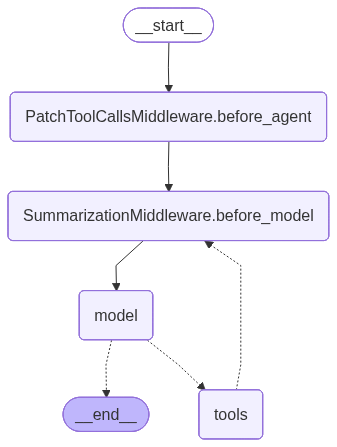

In [4]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

## Clean Up Previous Demo Files

In [5]:
from pathlib import Path

output_dir = Path("output")
if output_dir.exists():
    for f in output_dir.glob("*.md"):
        f.unlink()
    for f in output_dir.glob("*.json"):
        f.unlink()
    print("Previous demo files cleaned up.")
else:
    output_dir.mkdir(exist_ok=True)
    print("Output directory created.")

Previous demo files cleaned up.


## Test the Orchestrator

Watch for:
1. **Planning** with write_todos
2. **Canvas initialization** with start_new_canvas
3. **Batch saving** with save_section_answers
4. **Delegation** to compliance-advisor via task

In [6]:
from examples.utils import format_messages

# Test 1: Start a new ideation session
print("=" * 80)
print("TEST 1: Start ideation - Expect write_todos THEN start_new_canvas")
print("=" * 80)

result1 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "I have an idea for an AI solution: a document classification system that automatically categorizes incoming support tickets to route them to the right team.",
            }
        ],
    },
)
format_messages(result1["messages"])

TEST 1: Start ideation - Expect write_todos THEN start_new_canvas


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I have an idea for an AI solution: a document classification system that automatically categorizes incoming     │
│ support tickets to route them to the right team.                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ (No content)                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [7]:
# Test 2: Provide stakeholder information (batch save opportunity)
print("\n" + "=" * 80)
print("TEST 2: Stakeholders - Expect save_section_answers (batch) or multiple save_answer")
print("=" * 80)

result2 = agent.invoke(
    {
        "messages": result1["messages"]
        + [
            {
                "role": "user",
                "content": """Here are all the stakeholders:
- Problem owner: Lisa Chen, Head of Customer Support
- Budget owner: David Park, CFO
- Technical owner: Raj Patel, Engineering Manager
- Executive sponsor: Maria Santos, COO""",
            }
        ],
    },
)
format_messages(result2["messages"][-5:])


TEST 2: Stakeholders - Expect save_section_answers (batch) or multiple save_answer


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I have an idea for an AI solution: a document classification system that automatically categorizes incoming     │
│ support tickets to route them to the right team.                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ (No content)                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here are all the stakeholders:                                                                                  │
│ - Problem owner: Lisa Chen, Head of Customer Support                                                            │
│ - Budget owner: David Park, CFO                                                                                 │
│ - Technical owner: Raj Patel, Engineering Manager                                                               │
│ - Executive sponsor: Maria Santos, COO                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ (No content)                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [8]:
# Test 3: Check progress
print("\n" + "=" * 80)
print("TEST 3: Check progress - Shows section-by-section completion")
print("=" * 80)

result3 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Show me the current progress.",
            }
        ],
    },
)
format_messages(result3["messages"])


TEST 3: Check progress - Shows section-by-section completion


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Show me the current progress.                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: get_canvas_progress                                                                               │
│    Args: {}                                                                                                     │
│    ID: 3a2e2132-09c8-4057-84c1-25601dd1bbe0                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Canvas Progress                                                                                               │
│                                                                                                                 │
│ **Use Case:**                                                                                                   │
│ **Started:** 2026-01-21T07:57:58.119042                                                                         │
│ **Last Updated:** Not yet                                                                                       │
│ **Status:** in_progress                                                                                         │
│                                                                                                                 │
│ ## Section Progress                                                                                             │
│                                                                                                                 │
│ | Section | Total | Answered | Required | Req. Done |                                                           │
│ |---------|-------|----------|----------|----------|                                                            │
│ | S1: Stakeholders | 4 | 0 | 4 | 0 |                                                                            │
│ | S2: Problem & Goal | 4 | 0 | 3 | 0 |                                                                          │
│ | S3: Value Proposition | 4 | 0 | 4 | 0 |                                                                       │
│ | S4: Classification | 4 | 0 | 4 | 0 |                                                                          │
│ | S5: Data Requirements | 5 | 0 | 5 | 0 |                                                                       │
│ | S6: Data Privacy | 3 | 0 | 3 | 0 |                                                                            │
│ | S7: IT Security | 2 | 0 | 2 | 0 |                                                                             │
│ | S8: EU AI Act | 2 | 0 | 2 | 0 |                                                                               │
│ | S9: Summary & Next Steps | 4 | 0 | 3 | 0 |                                                                    │
│                                                                                                                 │
│ **Overall:** 0/32 (0%)                                                                                          │
│ **Required:** 0/30 answered                                                                                     │
│                                                                                                                 │
│ ### Unanswered Required Questions                                                                               │
│                                                                                                                 │
│ - **Q1.1**: Problem Owner (Stakeholders)                                                                        │
│ - **Q1.2**: Budget Owner (Stakeholders)                                                                         │
│ - **Q1.3**: Technical Owner (Stakeholders)                                                                      │
│ - **Q1.4**: Executive Sponsor (Stakeholders)                                                                    │
│ - **Q2.1**: Problem Statement (Problem & Goal)                                                                  │
│ - **Q2.2**: Goal Statement (Problem & Goal)                                                                     │
│ - **Q2.3**: Success Metrics (Problem & Goal)                                                                    │
│ - **Q3.1**: Value Type (Value Proposition)             

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The canvas is currently empty. No questions have been answered yet.                                             │
│                                                                                                                 │
│ Here's a quick overview:                                                                                        │
│                                                                                                                 │
│ *   **Overall Progress:** 0/32 questions answered (0%)                                                          │
│ *   **Required Questions:** 0/30 answered                                                                       │
│                                                                                                                 │
│ We need to go through all sections to fill out the canvas. Would you like to start with Section 1:              │
│ Stakeholders?                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
# Test 4: Ask about compliance - should delegate to subagent
print("\n" + "=" * 80)
print("TEST 4: Compliance question - Expect task(compliance-advisor)")
print("=" * 80)

result4 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Is a ticket classification system that processes customer messages considered high-risk under the EU AI Act? Give me detailed compliance guidance.",
            }
        ],
    },
)
format_messages(result4["messages"])


TEST 4: Compliance question - Expect task(compliance-advisor)


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Is a ticket classification system that processes customer messages considered high-risk under the EU AI Act?    │
│ Give me detailed compliance guidance.                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ (No content)                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Debug: Inspect Message Structure

If AI messages appear empty, use this cell to inspect the raw message structure.

In [11]:
# Debug: Inspect raw message structure for AI messages
def debug_messages(messages, last_n=5):
    """Show raw structure of recent messages for debugging."""
    print("=" * 60)
    print(f"Inspecting last {last_n} messages")
    print("=" * 60)

    for i, msg in enumerate(messages[-last_n:]):
        print(f"\n--- Message {i + 1} ---")
        print(f"Type: {type(msg).__name__}")
        print(f"msg.type: {getattr(msg, 'type', 'N/A')}")

        # Content
        content = getattr(msg, "content", None)
        print(f"Content type: {type(content).__name__}")
        print(f"Content empty: {not content if isinstance(content, (str, list)) else 'N/A'}")
        if content:
            content_preview = str(content)[:200] + "..." if len(str(content)) > 200 else str(content)
            print(f"Content: {content_preview}")

        # Tool calls (standard format)
        tool_calls = getattr(msg, "tool_calls", None)
        print(f"tool_calls: {tool_calls if tool_calls else 'None/Empty'}")

        # Additional kwargs (Gemini may store tool calls here)
        additional = getattr(msg, "additional_kwargs", {})
        if additional:
            print(f"additional_kwargs keys: {list(additional.keys())}")
            if "function_call" in additional:
                print(f"  function_call: {additional['function_call']}")
            if "tool_calls" in additional:
                print(f"  tool_calls: {additional['tool_calls']}")


# Uncomment and run to debug:
debug_messages(result1["messages"])

Inspecting last 5 messages

--- Message 1 ---
Type: HumanMessage
msg.type: human
Content type: str
Content empty: False
Content: I have an idea for an AI solution: a document classification system that automatically categorizes incoming support tickets to route them to the right team.
tool_calls: None/Empty

--- Message 2 ---
Type: AIMessage
msg.type: ai
Content type: str
Content empty: True
tool_calls: None/Empty


## View Generated Files

In [ ]:
output_dir = Path("output")
print("Generated files:")
print("=" * 40)
for f in sorted(output_dir.iterdir()):
    if not f.name.startswith("."):
        print(f"- {f.name}")

In [ ]:
import json

# Display the current canvas state (file-based persistence)
canvas_file = output_dir / "current_canvas.json"
if canvas_file.exists():
    print("Canvas State (from file, not context window):")
    print("=" * 40)
    data = json.loads(canvas_file.read_text())
    print(f"Use Case: {data.get('use_case_name')}")
    print(f"Status: {data.get('status')}")
    print(f"Answers: {len(data.get('answers', {}))} questions answered")
    print()
    print("Answers:")
    for qid, answer_data in data.get("answers", {}).items():
        print(f"  {qid}: {answer_data['answer'][:50]}...")

## Summary

### Tool Design Principles

| Principle | Implementation |
|-----------|----------------|
| Clear naming | `get_canvas_overview` not `load_canvas_template` |
| Single responsibility | `save_answer` (one) vs `save_section_answers` (batch) |
| LLM-friendly | `get_question(Q3.1)` for drilling into specifics |
| No context bloat | State in JSON file, not conversation history |
| Coherent with native | Custom tools complement `write_todos`, `task`, etc. |

### Tool Organization

```
Custom Tools (10)              Native Tools (4)
─────────────────              ────────────────
INIT:     start_new_canvas     PLAN:     write_todos
NAVIGATE: get_canvas_overview  DELEGATE: task
          get_section          FILES:    write_file
          get_question                   read_file
SAVE:     save_answer
          save_section_answers
REVIEW:   get_canvas_progress
          get_canvas_answers
EXPORT:   assess_compliance_flags
          generate_canvas_export
```

### State Management

All 32 question answers are stored in `output/current_canvas.json`, NOT in the context window:
- Keeps context lean for long conversations
- Allows both orchestrator and subagent to access same data
- Persists across sessions